We use the [BERTopic library](https://maartengr.github.io/BERTopic/) for topic modeling, leveraging a technique based on [transformers](https://huggingface.co/docs/transformers/) embeddings and c-TF-IDF statistics to divide the comments into separate topics. These comments are grouped into topics based on their embeddings using [UMAP](https://umap-learn.readthedocs.io/) and [HDBSCAN](https://hdbscan.readthedocs.io/). UMAP reduces dimensions of the text embedding vectors and allows HDBSCAN to better identify high-density clusters in the data. Each cluster is then assigned a set of representative keywords based on the most frequent words in it. Once labeled, the topics are assigned titles for identification and visualization. The topics are also organized in a hierarchy, which enables us to model relationship between different topics.

```{mermaid}
graph TD
    Vectors[Embedding Vectors]
    Clusters[Hierarchical Clusters]
    BagOfWords["Bag of Words (Per-Cluster)"]
    Keywords[Significant Keywords]
    Labels[Topic Labels]
    Representation[Topic Representation]

    Statements -- Transformers --> Vectors
    Vectors -- UMAP + HDBSCAN --> Clusters
    Clusters -- Vectorizer --> BagOfWords
    BagOfWords -- c-TF-IDF --> Keywords
    Keywords -- MMR + POS Filtering --> Representation
    Representation -- LLM --> Labels
```

## Import Packages and Setup Environment

In [2]:
import os
from pprint import pprint
from tqdm.notebook import tqdm

import polars as pl
from argmap.dataModel import Summary, Comments, Topics, HierarchicalTopics

from dotenv import load_dotenv
load_dotenv()

# this allows categorical data from various sources to be combined and handled gracefully; performance cost is acceptable
pl.enable_string_cache()

EMBED_MODEL_ID = os.getenv("EMBED_MODEL_ID")

In [3]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np

from umap import UMAP
from hdbscan import HDBSCAN

import torch

# prefer GPU for spacy if available
if torch.cuda.is_available():
	spacy.prefer_gpu()
	print("CUDA available; spacy will prefer GPU")

CUDA available; spacy will prefer GPU


### Verify GPU Availability

In [1]:
from argmap.helpers import printCUDAMemory, getTorchDeviceVersion

print(getTorchDeviceVersion())

printCUDAMemory()

Device: Orin
Python: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:26:55) [GCC 12.3.0]
PyTorch: 2.2.0a0+6a974be
CUDA: 12.2
CUDNN: 8904

CUDA Memory: 51.1 GB free, 0.0 GB allocated, 61.4 GB total


### Load Language Model

In [5]:
import os

from argmap.helpers import loadLanguageModel

CUDA_MINIMUM_MEMORY_GB = os.getenv("CUDA_MINIMUM_MEMORY_GB")
MODEL_ID = os.getenv("MODEL_ID")
MODEL_REVISION = os.getenv("MODEL_REVISION") or None

if MODEL_ID is None:
    raise Exception("MODEL_ID environment variable is required.")

if 'languageModel' not in globals():
    languageModel = loadLanguageModel(MODEL_ID, MODEL_REVISION, CUDA_MINIMUM_MEMORY_GB)

Initializing language model: TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ gptq-4bit-32g-actorder_True...
Language model initialized.
CUDA Memory: 51.5 GB free, 26.2 GB allocated, 79.1 GB total


### Run Model to Generate Titles

In [6]:
from tqdm.notebook import tqdm

import guidance
from guidance import user, assistant, instruction, gen, select
import re

from argmap.guidance import generate_phrase


@guidance
def generate_topic_headings_titles(lm, summary, topics, generate_titles=False, temperature=0, progress_bar=None):

    if progress_bar is not None:
        lm.echo = False

    # avoid repeating anything from conversation title
    taboo_words = re.split(r'\W+', summary.topic)

    with instruction():
        lm += f"""\
Assign a detailed title and a short heading to best represent each given topic.
Start with a noun or adjective.
Avoid repetitive words or phrases such as "Enhancing" or "Improving".
Avoid using these words: {', '.join(taboo_words)}

KEYWORDS: [a set of keywords that describe the topic]
STATEMENTS: [a set of statements that best represent the topic]
TITLE: [a descriptive sentence that represents the topic and starts with a noun]
HEADING: [terse phrase]
"""

    topic_titles = []
    topic_headings = []

    for topic, keywords, docs in topics.df.select('Topic', 'Representation', 'Representative_Docs').iter_rows():
        if topic == -1:
            topic_titles.append("Outliers")
            topic_headings.append("Outliers")
            progress_bar.update() if progress_bar is not None else None
            continue

        with user():
            lm_topic = lm + f"""
            # Topic {topic}
            KEYWORDS: {', '.join(keywords)}
            STATEMENTS: {'; '.join(docs)}
            """
        with assistant():
            if generate_titles:
                lm_topic += f"TITLE: " + generate_phrase('title', temperature, 50) + '\n'
            lm_topic += f"HEADING: " + generate_phrase('heading', temperature, 12) + '\n'

        if generate_titles:
            topic_titles.append(lm_topic['title'])

        topic_headings.append(lm_topic['heading'])

        progress_bar.update() if progress_bar is not None else None

    if generate_titles:
        topics.addColumns(pl.Series('Title', topic_titles))

    topics.addColumns(pl.Series('Heading', topic_headings))

    return lm

## Statements and Embeddings

We load our dataset and embeddings that we computed during data ingestion. For this experiment, we continue to use the [intfloat/e5-mistral-7b-instruct](https://huggingface.co/intfloat/e5-mistral-7b-instruct) embedding model.

In [7]:
from IPython.display import display_markdown

DATASET = "american-assembly.bowling-green"

comments = Comments(DATASET).load_from_parquet()
summary = Summary(DATASET)

comments_df = (
    comments.df
    .filter(pl.col('moderated') >= 0)
    .sort('agreeability')
    .select('commentId', 'commentText', embedding=f'embedding-{EMBED_MODEL_ID}')
)

documents = comments_df.get_column('commentText').to_list()
embeddings = comments_df.get_column('embedding').to_numpy()

# Convert list of numpy arrays to 2D numpy array
embeddings = np.array([np.array(embedding) for embedding in embeddings])

display_markdown(f"""
### Dataset: {DATASET}
#### {summary.topic}
#### {summary.get('conversation-description')}
#### Full Report: [{summary.url}]({summary.url})
#### Embedding Model: {EMBED_MODEL_ID}
#### Dimensions: {len(embeddings[0])}
""", raw=True)


### Dataset: american-assembly.bowling-green
#### Improving Bowling Green / Warren County
#### What do you believe should change in Bowling Green/Warren County in order to make it a better place to live, work and spend time?
#### Full Report: [https://pol.is/9wtchdmmun](https://pol.is/9wtchdmmun)
#### Embedding Model: WhereIsAI/UAE-Large-V1
#### Dimensions: 1024


## Dimensionality Reduction

We use [Uniform Manifold Approximation and Projection (UMAP)](https://umap-learn.readthedocs.io/) to reduce the text embedding vectors dimensions. Our embeddings from `intfloat/e5-mistral-7b-instruct` model have 4096 dimensions while `WhereIsAI/UAE-Large-V1` model outputs 1024 dimensions. We employ a density based clustering algorithm and high dimensionality makes it nearly impossible to identify any high-density regions. Therefore we translate these embeddings to a lower dimension space below 100 dimensions as recommended in the official UMAP documentation. This significantly improves the performance efficiency of the clustering algorithm, allowing it to better identify high-density clusters in the data.

In the following experiments, we attempt to optimize the following UMAP parameters:

- n_neighbors
- n_components
- min_dist
- metric

In [ ]:
import matplotlib.pyplot as plt
import umap.plot
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

umap.plot.output_notebook()


def plot_umap_diagnostic(embeddings, diagnostic_type='pca', topics=None, ax=None, **kwargs):
    args = kwargs | {'n_components': 2}
    mapper = UMAP(**args).fit(embeddings)
    # labels = np.array(topics) if topics is not None else None
    # umap.plot.connectivity(mapper, ax=ax, show_points=True, labels=labels)
    umap.plot.diagnostic(mapper, diagnostic_type=diagnostic_type, ax=ax)

### `n_neighbors`

This parameter constrains the size of local neighborhoods, balancing local details against global structure of data. Higher values favor global structure. Clustering algorithms typically depend on the local relationships between points, so a lower value is preferred. We experiment with values $[2, 4, 8, 16, 32, 64]$. At n_neighbors = 2 and 4, the graphs fails to reveal any meaningful clusters. We select n_neighbors = 8 as the optimal value as the graph begins to take a more meaningful shape.

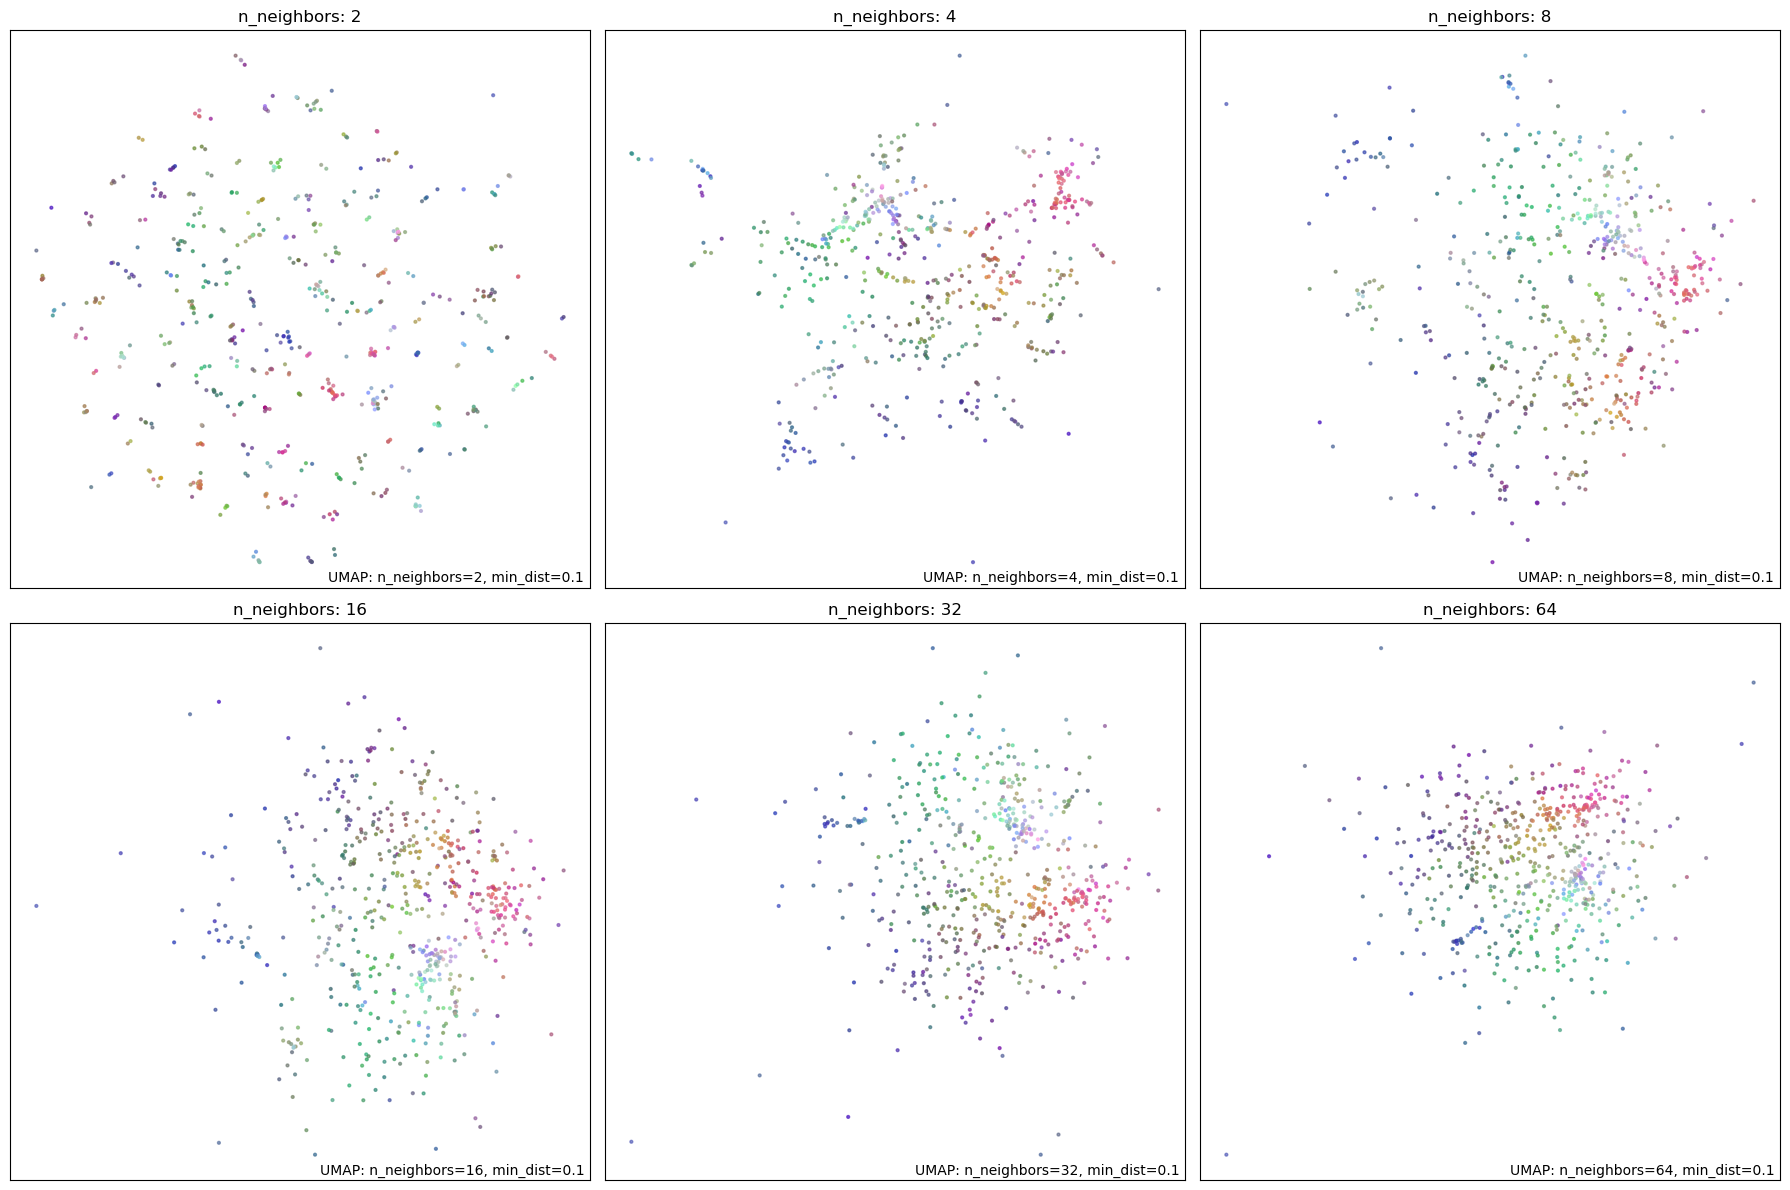

In [8]:
# list powers of 2 up to quarter of the total number of points
n_neighbors_values = [2**i for i in range(1, int(np.log2(comments_df.height / 4)))]

num_plots = len(n_neighbors_values)
num_columns = 3
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

fig, axs = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 6))
axs = axs.flatten()  # Flatten the array to easily iterate over it

for i, n in enumerate(n_neighbors_values):
    plot_umap_diagnostic(embeddings, diagnostic_type='pca', ax=axs[i], n_neighbors=n, densmap=True, random_state=42)
    axs[i].set_title(f'n_neighbors: {n}')

plt.tight_layout()
plt.show()

### `min_dist`

This parameter specifies how closely the points can be located in a low-dimensional space. Higher values typically result in more evenly distributed points at the expense of local structure. Lower values allow clumping, which is not ideal for visualization but is more useful for clustering. We experiment with values $[0.0, 0.1, 0.25, 0.5, 0.8, 0.99]$ to demonstrate the effect of this parameter. We select min_dist = 0 to best preserve local structure for clustering.

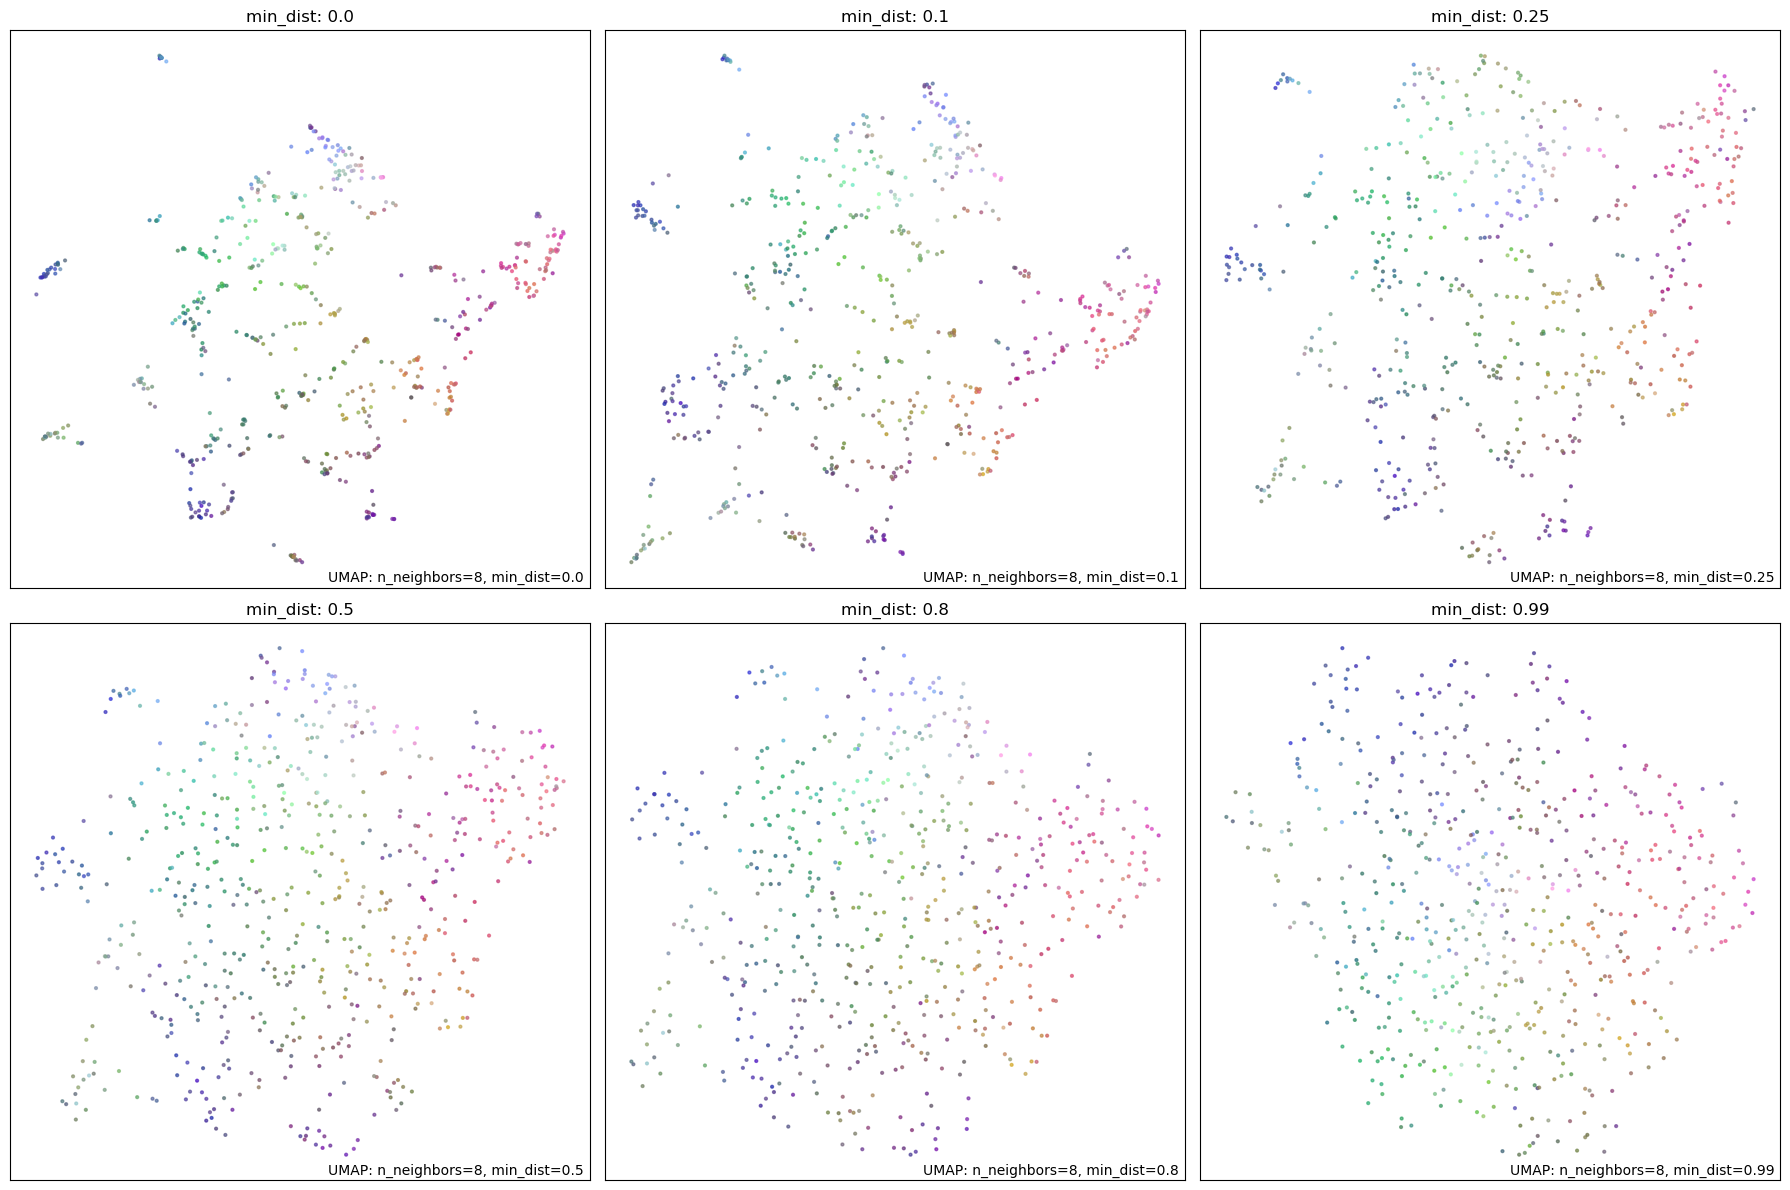

In [9]:
min_dist_values = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

num_plots = len(min_dist_values)
num_columns = 3
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

fig, axs = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 6))
axs = axs.flatten()  # Flatten the array to easily iterate over it

for i, min_dist in enumerate(min_dist_values):
    plot_umap_diagnostic(embeddings, diagnostic_type='pca', ax=axs[i], min_dist=min_dist, n_neighbors=8, random_state=42)
    axs[i].set_title(f'min_dist: {min_dist}')

plt.tight_layout()
plt.show()

### `n_components`

This parameter specifies the number of dimensions in the reduced space. Since the 2D graphs are always limited to two dimensions, in this experiment, we first reduce the data to our selected value of `n_components` and then further reduce it to 2D for visualization. We experiment with values $[8, 16, 32, 64, 128, 256]$ to visualize the effect of this parameter. UMAP documentation recommends setting this anywhere from $10$ to $100$. An excessively high value might defeat the purpose of dimensionality reduction. Either $16$ or $32$ is a reasonable choice. We set it to $32$ to allow for a high accuracy while still allowing HDBSCAN to identify high-density clusters.

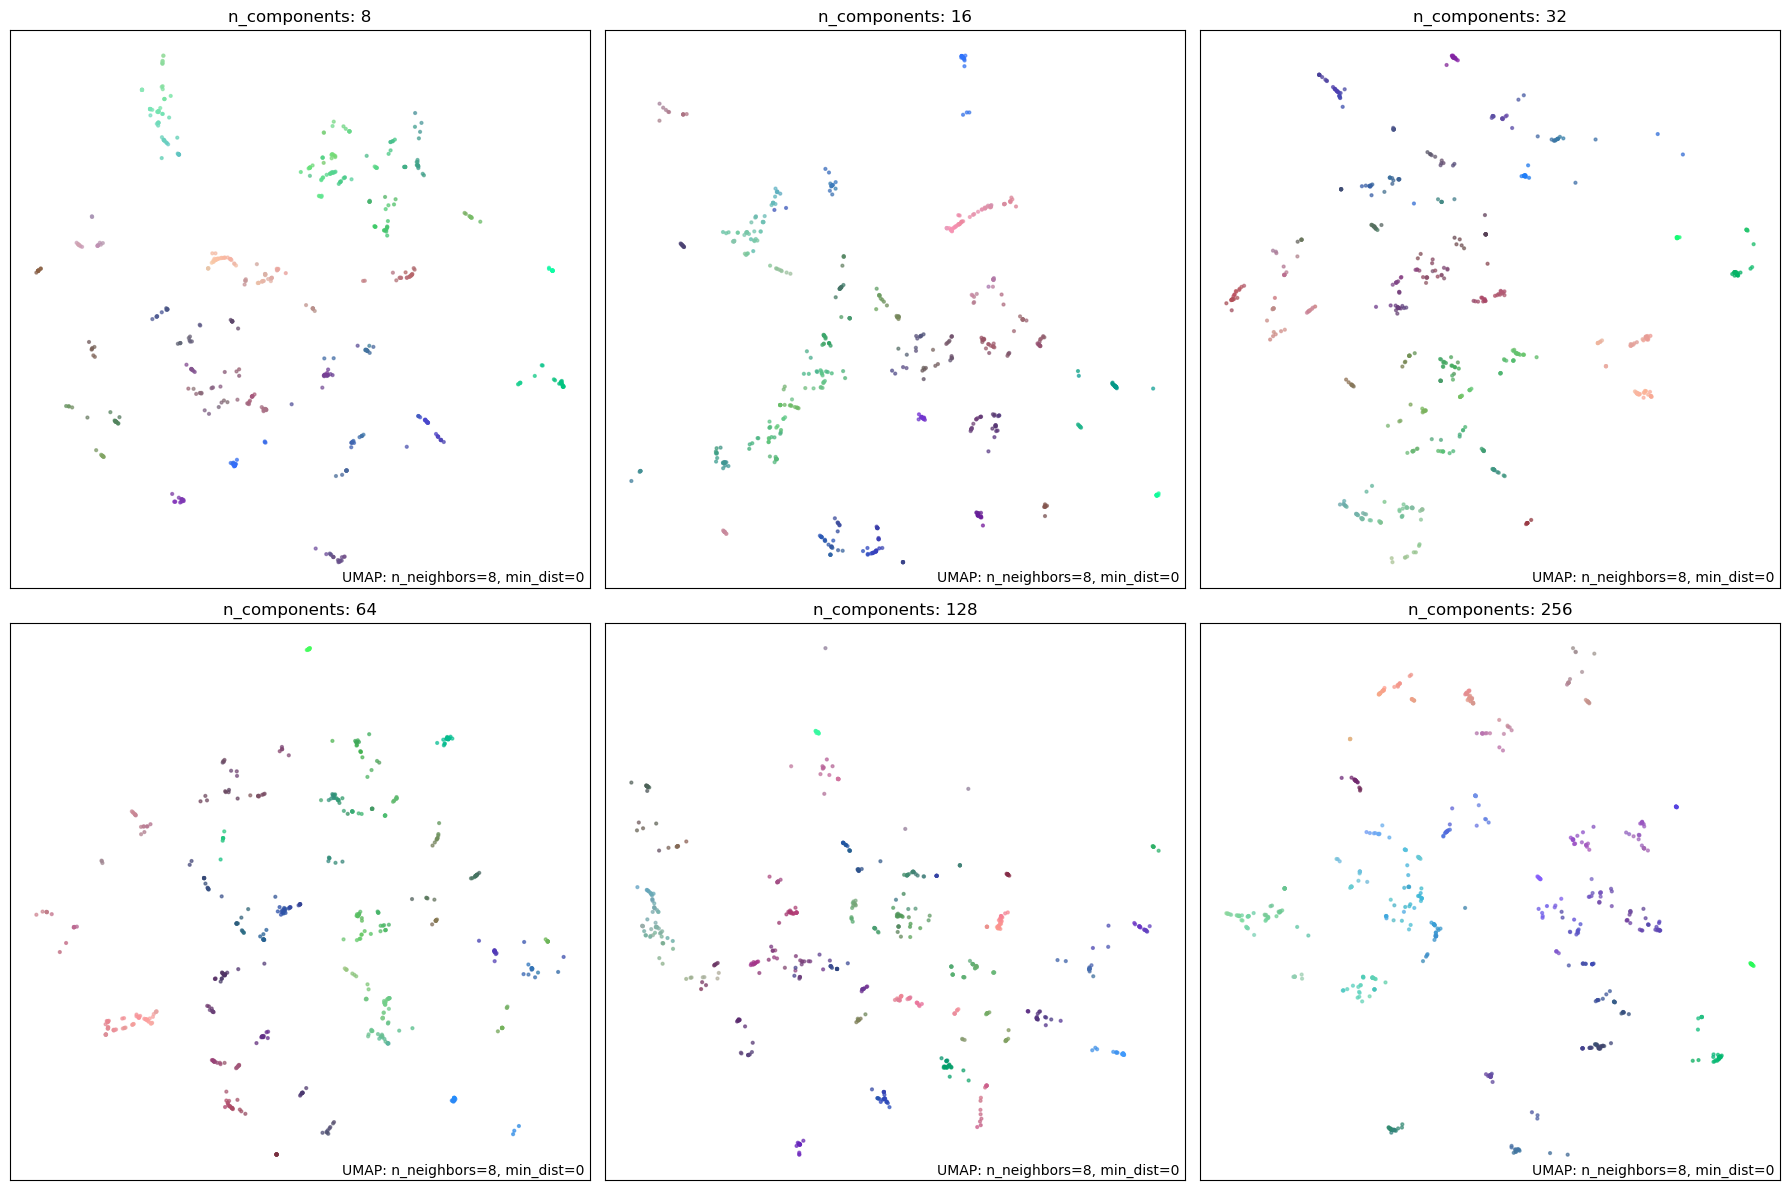

In [10]:
n_components_values = [8, 16, 32, 64, 128, 256]

num_plots = len(n_components_values)
num_columns = 3
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

fig, axs = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 6))
axs = axs.flatten()

for i, n in enumerate(n_components_values):
    reduced_embeddings = UMAP(n_components=n, n_neighbors=8, min_dist=0).fit(embeddings).embedding_
    plot_umap_diagnostic(reduced_embeddings, diagnostic_type='pca', ax=axs[i], n_neighbors=8, min_dist=0, densmap=True, random_state=42)
    axs[i].set_title(f'n_components: {n}')

plt.tight_layout()
plt.show()

### `metric`

Finally, we test various distance metrics to determine the best one for our data. We experiment with euclidean, minkowski, and cosine metrics. All three metrics appear to perform similarly. However, since we are dealing with a high dimensional space and our vectors may not be normalized, cosine metric will perform the best to recognize semantic similarity. We select `cosine` metric as the optimal choice for our data.

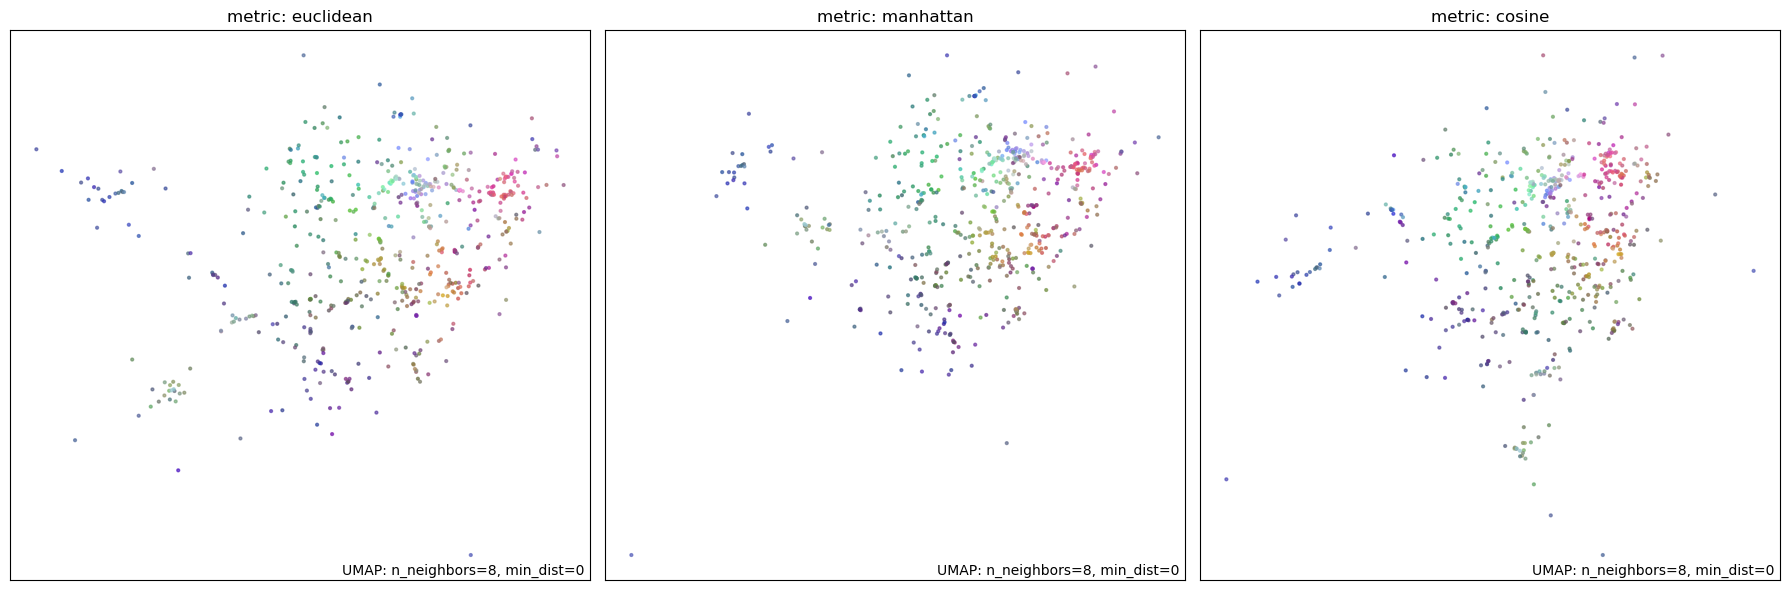

In [11]:
metrics_values = ['euclidean', 'manhattan', 'cosine']

num_plots = len(metrics_values)
num_columns = 3
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

fig, axs = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 6))
axs = axs.flatten()

for i, metric in enumerate(metrics_values):
    plot_umap_diagnostic(embeddings, diagnostic_type='pca', ax=axs[i], metric=metric, n_neighbors=8, min_dist=0, densmap=True, random_state=42)
    axs[i].set_title(f'metric: {metric}')

plt.tight_layout()
plt.show()

### Selected Parameters
- `n_neighbors`: 8
- `min_dist`: 0.0
- `n_components`: 32
- `metric`: cosine

Additionally, setting `densmap=True` significantly improves the clustering results. It "computes estimates of the local density and uses those estimates as a regularizer in the optimization of the low dimensional representation", which significantly helps HDBSCAN identify clusters.

With these parameters, we generate a final projection of our embeddings dataset. The first figure shows the 2D projection of the embeddings resulting from the UMAP model. The second figure shows a network connectivity graph that highlights the distance between various points in a 2D space. The edge thickness represents the distance between the points. This graph shows a high-density core and several outliers, which is consistent with a scale-free network and is ideal for clustering.

Reference:

- [densMAP: Density-Preserving Data Visualization Unveils Dynamic Patterns of Single-Cell Transcriptomic Variability](https://www.biorxiv.org/content/10.1101/2020.05.12.077776v1)


In [12]:
from sklearn.decomposition import PCA
import umap.plot

umap_params = dict(
    n_neighbors=8,
    min_dist=0.0,
    n_components=32,  # this is the new dimensionality
    metric='cosine',
    random_state=42,
    densmap=True,
)

umap_model = UMAP(**umap_params)

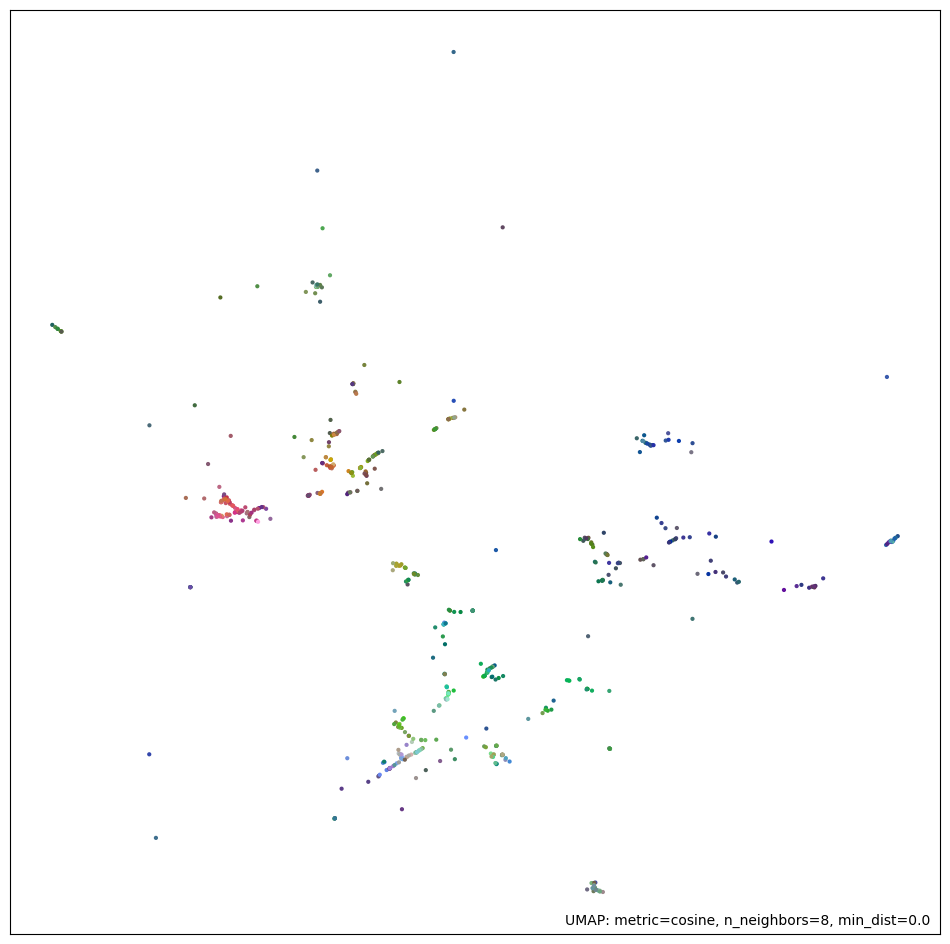

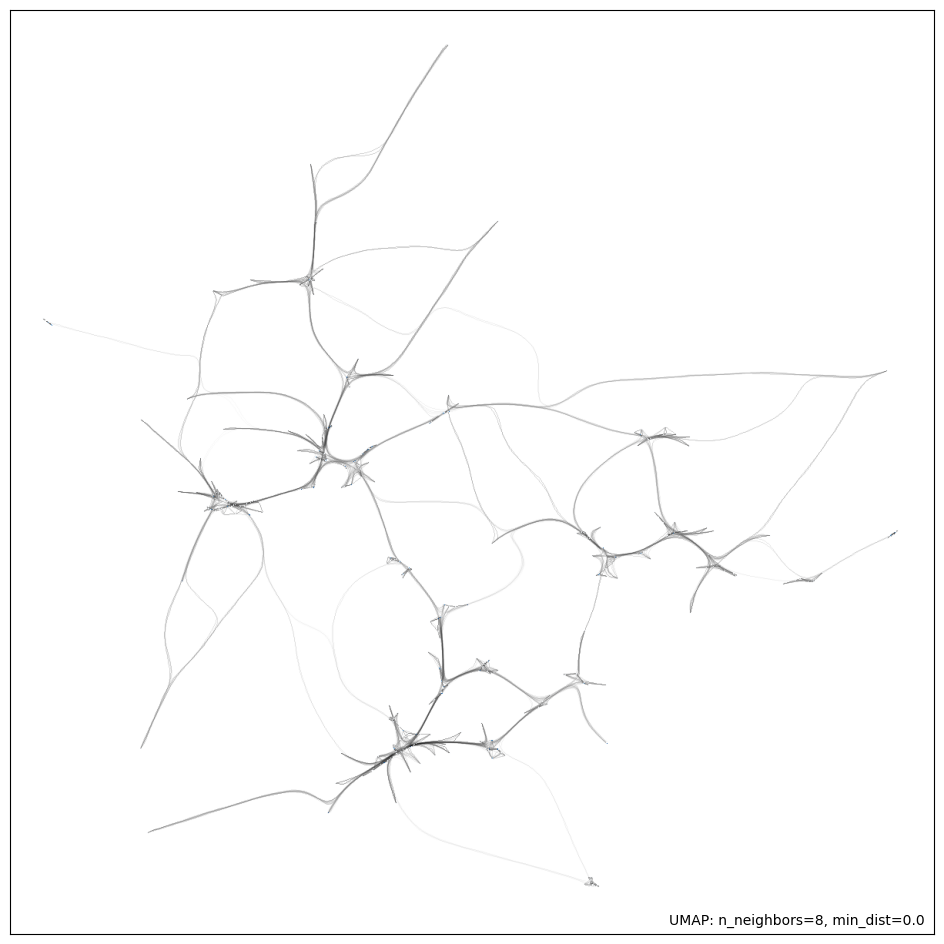

In [13]:
def plot_umap_result(embeddings, umap_model):
    reduced_embeddings = umap_model.fit_transform(embeddings)

    # use PCA to represent the original embeddings in RGB color space while generally preserving global structure
    pca_result = PCA(n_components=3).fit_transform(embeddings)
    pca_color = (pca_result - np.min(pca_result, axis=0)) / np.ptp(pca_result, axis=0)

    # project the embeddings into a 2D space for visualization
    mapper = UMAP(**(umap_params | {'n_components': 2})).fit(reduced_embeddings)
    umap.plot.points(mapper, values=pca_color, width=1200, height=1200)
    umap.plot.connectivity(mapper, show_points=True, edge_bundling='hammer', width=1200, height=1200)

plot_umap_result(embeddings, umap_model)

## Clustering

We use [HDBSCAN](https://hdbscan.readthedocs.io/) to cluster the reduced dimensions of the text embedding vectors. HDBSCAN is a density-based clustering algorithm particularly well-suited for clustering data with noise and varying densities. We tune the parameters for clustering using trial and error to optimize the following outputs:
- Number of clusters / topics
- Number of outliers

Future work will include using [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) for comparison and the use of silhouette score to evaluate the quality of the clusters.

In [14]:
hdbscan_params = dict(
    min_cluster_size=comments_df.height // 50, # 2% of the statement count
    min_samples=1,  # a higher default value makes clustering more conservative
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
    gen_min_span_tree=True,
)

hdbscan_model = HDBSCAN(**hdbscan_params)

pprint(hdbscan_params)

{'cluster_selection_method': 'eom',
 'gen_min_span_tree': True,
 'metric': 'euclidean',
 'min_cluster_size': 12,
 'min_samples': 1,
 'prediction_data': True}


## Vectorizer and c-TF-IDF

We use a count-based vectorizer to convert the text into a matrix of token counts while conisdering n-grams of up to two words. We then apply a term frequency-inverse document frequency (TF-IDF) transformation to the count matrix.

### Stop Words

Vectorizer uses a list of stop words to filter out common words that are unlikely to be useful for clustering. Stop words are the most frequent words that provide structure but add little meaning to the specific topic. We consider them as noise and remove them from the text before clustering.

We use Spacy's stop words list for English language. Additionally, we add custom stop words from the discussion summary, since they apply to the entire discussion and are likely to appear in each topic without adding specific semantic value. For example, for our currently select dataset, the discussion summary is "Improving Bowling Green / Warren County", and all of these words tend to appear in many statement. We add these words to our stop words list to minimize noise and focus on signal.

This technique improves the signal-to-noise ratio (SNR) and allows us to focus on the most meaningful words in each statement.

In [15]:
import re

summary_stop_words = re.split(r'\W+', summary.topic.lower())

summary_stop_words

['improving', 'bowling', 'green', 'warren', 'county']

In [16]:
# TODO: consider using number of votes to prioritize more agreeable statements
vectorizer_model = CountVectorizer(stop_words=(list(STOP_WORDS) + summary_stop_words), ngram_range=(1, 2))

# TODO try bm25_weighting=True to reduce frequent words
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

## Topic Representation

We use Spacy to apply a part-of-speech filter to only include nouns and adjective-noun pairs in our representative keywords. We then employ Maximal Marginal Relevance (MMR) to select the most representative keywords for each topic while maintaining diversity.

In [17]:
pos_patterns = [
            [{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}]
]

representation_model = [
	PartOfSpeech("en_core_web_lg", pos_patterns=pos_patterns),
	MaximalMarginalRelevance(diversity=0.3),
]

## Creating Topic Model


Future work involves identifing appropriate validation metrics, e.g. cluster size, silhouette score, largest topic, number of outliers etc. and using GridSearchCV to optimize the HDBSCAN hyperparameters. Additionally, clusters larger than a certain size may be further divided to improve granularity.

References-

- https://towardsdatascience.com/tuning-with-hdbscan-149865ac2970
- https://github.com/MaartenGr/BERTopic/issues/611
- https://gist.github.com/drob-xx/1d8408f24f4091c72e8d03dc7a451be7

In [18]:
from sklearn.metrics import silhouette_score

topic_model = BERTopic(
    umap_model=umap_model,					 # Reduce dimensionality
    hdbscan_model=hdbscan_model,				# Cluster reduced embeddings
    vectorizer_model=vectorizer_model,		 # Tokenize topics
    ctfidf_model=ctfidf_model,				 # Extract topic words
    representation_model=representation_model,  # Fine-tune topic representations
    # calculate_probabilities=True,
    nr_topics="auto",
)

topic_assignments, probabilities = topic_model.fit_transform(documents, embeddings)

print(f"""
Number of comments: {len(documents)}
Number of topics: {len(topic_model.get_topic_freq()) - 1}
Outliers: {topic_assignments.count(-1)}
Largest Cluster: {topic_assignments.count(0)}
Silhouette Score: {silhouette_score(embeddings, topic_assignments, metric='cosine')}
Relative Validity: {topic_model.hdbscan_model.relative_validity_}
""")


Number of comments: 607
Number of topics: 14
Outliers: 229
Largest Cluster: 70
Silhouette Score: 0.008188310079276562
Relative Validity: 0.16012470901699025



### List of generated topics

In [19]:
for topic, words in topic_model.get_topics().items():
    if topic == -1:
        continue
    keywords = ', '.join([word[0] for word in words])
    print(f'Topic {topic}: {keywords}')

Topic 0: tax, vote, taxes, wage, officials, homelessness, city, laws, limits, homeless people
Topic 1: traffic, road, lane, flow, bypass, roads, turn, lights, congestion, cemetery
Topic 2: ordinance, fairness, city, noise, lawns, separation, code, food, officials, improvement
Topic 3: parking, campus, students, garage, college, miles, food, police, downtown, lots
Topic 4: planning, zoning, parks, small businesses, development, neighborhoods, single family, family, apartments, city
Topic 5: drug, opioid, doctors, deaths, pain, crisis, dealers, problem, dependency, opioids
Topic 6: school, schools, arts, choice, kids, districts, public school, charter, education, parents
Topic 7: complex, university, facilities, sports, programs, community, psych, educational establishments, sport, cultural activities
Topic 8: sidewalks, trails, bike, walking, bicycle, connectivity, future sidewalks, ramps, paved trail, biking
Topic 9: water, fire, lines, residents, expensive insurance, maps, new roads, 

## Generate Topic Headings using Language Model

Here, we simply call certain pre-defined functions to generate the headings and titles. We explore these specific techniques with various language models in the next notebook.

In [ ]:
topics = Topics(
    DATASET,
    df=pl.from_pandas(topic_model.get_topic_info())
)

progress_bar = tqdm(
    total=topics.df.height,
    desc='Topic Titles',
    unit="topics",
    smoothing=0.1,
)

languageModel + generate_topic_headings_titles(
    summary,
    topics,
    progress_bar=progress_bar
)

progress_bar.close()

topic_model.set_topic_labels(
    topics.df.get_column('Heading').to_list()
)

In [21]:
from IPython.display import display_markdown

output = "### Generated Headings:\n- " + \
    "\n- ".join(topics.df.get_column('Heading').to_list())
display_markdown(output, raw=True)

### Generated Headings:
- Outliers
- Addressing Homelessness and Taxation
- Traffic Management
- Opposing Fairness Ordinance
- College Campus Improvements
- Improving City Planning and Zoning
- Opioid Crisis and Doctors
- Improving Arts Education in Public Schools
- University-Based Community Enrichment
- Enhanced Pedestrian Infrastructure
- Water and Fire Protection in Tuckertown
- Expanding Internet Options
- Legalized Marijuana Benefits
- Improving Waste Management
- Improved Public Transit

## Outlier Analysis

### Comment Distribution

The following graph shows the comment embeddings projected in 2D space. The color represents the topic. Several outliers are visible in gray color indicating a lack of topic assignment.

In [23]:
topic_model.visualize_documents(
    documents,
    embeddings=embeddings,
    title="",
    custom_labels=True
)

### Topic Distribution

The following distribution shows a reasonably balanced number of comments per topic with the exception of first topic. There are also a significant number of outliers with the label $-1$. In the following steps, we will assign these outliers to the most similar topic.

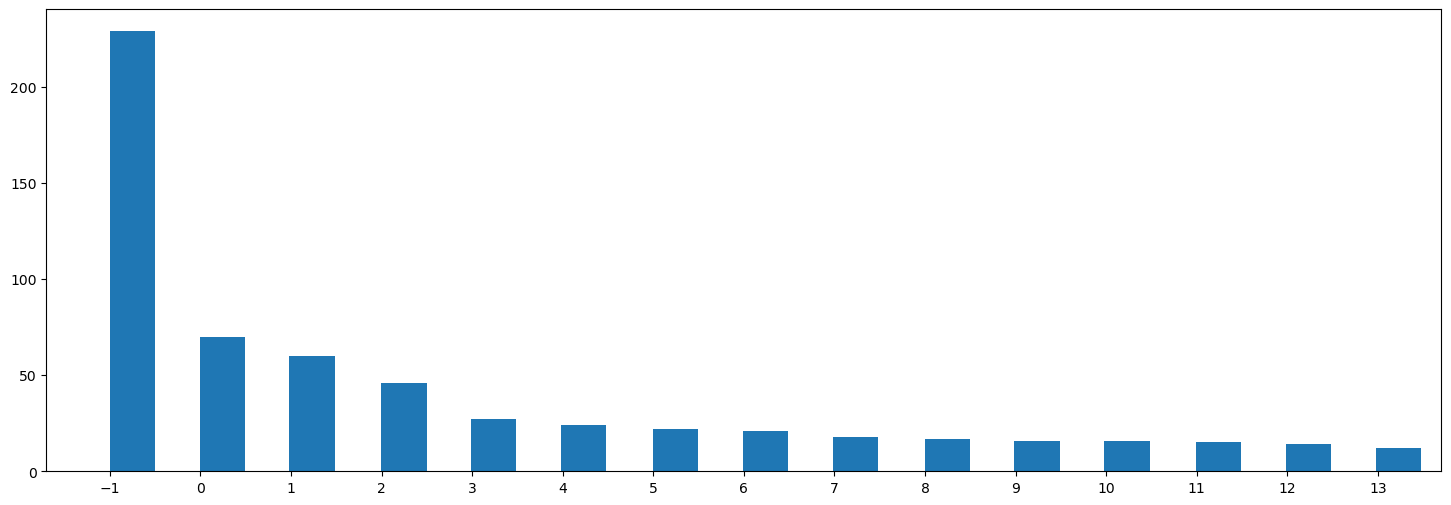

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.xticks(range(int(min(topic_assignments)), int(max(topic_assignments)) + 1))
plt.hist(topic_assignments, bins=len(topic_assignments), width=0.5)
plt.show()

### Assign outliers to closest topic

We assign outlier comments to the nearest topic based on the probability distribution calculated by BERTopic. If outliers still remain that do not appear to belong to any topic, we assign them based on embedding similarity to the topic centroids. This ensures that all comments are considered in our further analysis and not silently discarded.

Future work will include further analysis of the outliers to isolate noise and improve the quality of the topics.

Outliers: 229
Assigning outliers to topics using embeddings...
Outliers remaining: 0


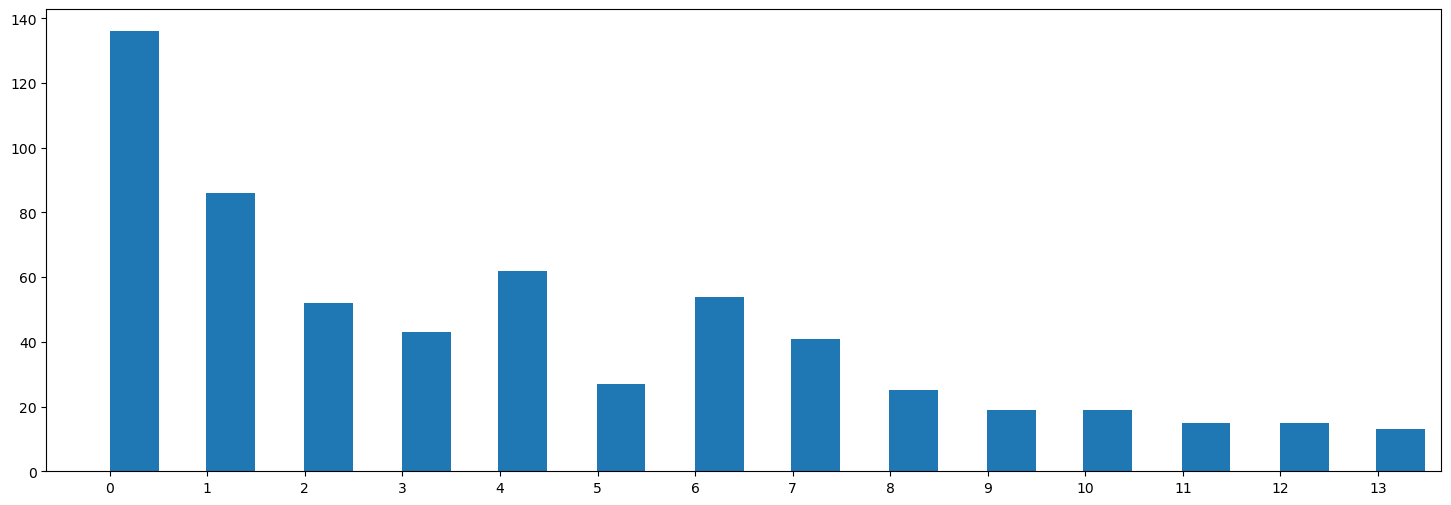

In [25]:
outliers = topic_assignments.count(-1)

print(f"Outliers: {outliers}")

if topic_assignments.count(-1) > 0:
    print("Assigning outliers to topics using embeddings...")
    topic_assignments = topic_model.reduce_outliers(
        documents,
        topic_assignments,
        strategy='embeddings',
        embeddings=embeddings
    )
    print("Outliers remaining:", topic_assignments.count(-1))

if topic_assignments.count(-1) > 0:
    print("Assigning outliers to topics using c-TF-IDF based probability distributions...")
    topic_assignments = topic_model.reduce_outliers(
        documents,
        topic_assignments,
        strategy='distributions'
    )
    print("Outliers remaining:", topic_assignments.count(-1))

plt.figure(figsize=(18, 6))
plt.xticks(range(int(min(topic_assignments)), int(max(topic_assignments)) + 1))
plt.hist(topic_assignments, bins=len(topic_assignments), width=0.5)
plt.show()

### Update Topic Model with Outlier Assignments

In [26]:
topic_model.update_topics(documents, topics=topic_assignments, ctfidf_model=ctfidf_model,
						 vectorizer_model=vectorizer_model, representation_model=representation_model)

print(f'\nNumber of topics: {len(topic_model.get_topic_freq())}\n')

for topic, words in topic_model.get_topics().items():
	keywords = ', '.join([word[0] for word in words])
	print(f'Topic {topic}: {keywords}')

# for topic, keywords in enumerate(topic_model.get_topic_info()['Representation']):
#	 print(f"Topic {topic}: {', '.join(keywords)}")

2024-03-14 23:19:02,051 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



Number of topics: 14

Topic 0: homeless, pay, tax, taxes, city, people, vote, temp, officials, wage
Topic 1: traffic, road, flow, bypass, roads, lane, drivers, lights, intersection, turn
Topic 2: ordinance, fairness, city, noise, separation, lawns, code, food, officials, improvement
Topic 3: parking, campus, food, restaurants, students, garage, lots, apartment, space, college
Topic 4: planning, zoning, neighborhoods, parks, development, apartments, family, single family, neighbors, activities
Topic 5: drug, opioid, doctors, pain, deaths, crisis, treatment, dealers, problem, dependency
Topic 6: schools, school, education, students, parents, public school, public schools, kids, funding, arts
Topic 7: museum, complex, community, university, sports, concerts, youth, programs, art, activities
Topic 8: sidewalks, bike, trails, walking, trail, pedestrian, river, shade, trees, cars
Topic 9: water, fire, lines, counties, river, tourism, residents, waste, septic tanks, features
Topic 10: intern

#### Store Topic Assignments in Comment Dataframe

In [27]:
comments_df = comments_df.with_columns(topicId=pl.Series(topic_assignments))
comments.join_in_place(comments_df.select('commentId', 'topicId'), 'commentId', dropColumns='topicId').save_to_parquet()
print(f"Saved to {comments.filename}")

Saved to ./data-polis/american-assembly.bowling-green/comments.parquet


#### Re-generate topic headings based on updated model

In [28]:
topics = Topics(
    DATASET,
    df=pl.from_pandas(topic_model.get_topic_info())
)

progress_bar = tqdm(
    total=topics.df.height,
    desc='Topic Titles',
    unit="topics",
    smoothing=0.1,
)

languageModel + generate_topic_headings_titles(
    summary,
    topics,
    generate_titles=True,
    progress_bar=progress_bar
)

topics.save_to_parquet()
progress_bar.close()

topic_model.set_topic_labels(
    topics.df.get_column('Heading').to_list()
)

Topic Titles:   0%|          | 0/14 [00:00<?, ?topics/s]

In [29]:
from IPython.display import display_markdown

output = "### Updated Headings:\n- " + \
    "\n- ".join(topics.df.get_column('Heading').to_list())
display_markdown(output, raw=True)

### Updated Headings:
- Addressing Homelessness with Occupational Taxes
- Improving Traffic Flow
- No to Fairness Ordinance
- College Campus Improvements
- Improving City Planning and Zoning
- Opioid Epidemic and Healthcare
- Public School Funding and Accountability
- Community Enrichment Hub
- Pedestrian-Friendly Infrastructure
- Enhancing Community Safety and Tourism
- Internet Choices and Competition
- Marijuana Legalization
- Enhancing Recycling and Waste Management
- Improved Transit Services

### Generate Hierarchical Topic Tree

In [30]:
hierarchical_topics = topic_model.hierarchical_topics(documents)
hTopics = HierarchicalTopics(DATASET, df=hierarchical_topics)
hTopics.save_to_parquet()
print(f"Saved to {hTopics.filename}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.73it/s]


Saved to ./data-polis/american-assembly.bowling-green/hierarchicaltopics.parquet


## Visual and Interactive Analysis of Topics

### Comment Distribution without Outliers

In [31]:
topic_model.visualize_documents(
    documents,
    embeddings=embeddings,
    title="",
    custom_labels=True
)

### Inter-topic Distance Map

In [32]:
topic_model.visualize_topics(
    custom_labels=True,
    title='',
    width=1200,
)

### Hierarchical Clustering

In [33]:
# print(topic_model.get_topic_tree(hierarchical_topics)) # print a text representation of the topic tree
# hierarchical_topics = topic_model.hierarchical_topics(documents)


topic_model.visualize_hierarchy(
    custom_labels=True,
    orientation='left',
    title='',
    width=1000,
)

### Topic Correlation Heatmap

In [34]:
topic_model.visualize_heatmap(
    custom_labels=True,
    title='',
    width=1200,
    )

### Hierarchical Organization of Comments

In [35]:
topic_model.visualize_hierarchical_documents(
    documents,
    hierarchical_topics,
    embeddings=embeddings,
    custom_labels=True,
    title='',
    width=1200,
)